In [66]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import uproot
import random 
from scipy.stats import norm, moyal
from scipy.optimize import curve_fit
from iminuit import Minuit

In [2]:
def fit_track(z_track, x_track):
    
    mean_z = np.mean(z_track)
    mean_x = np.mean(x_track)
    # Total number of values
    n = len(z_track)
    # Using the formula to calculate 'm' and 'c'
    numer = 0
    denom = 0
    chisq = 0
    for i in range(n):
        numer += (z_track[i] - mean_z) * (x_track[i] - mean_x)
        denom += (z_track[i] - mean_z) ** 2
    m = numer / denom
    c = mean_x - (m * mean_z)
    
    return m, c

In [79]:
def run_tracks(filename, treename, B, pmin, pmax, distr):
    
    file = uproot.open(filename+'.root')
    tree = file[treename]
    branches = tree.arrays()
    momenta = []
    momenta_fit = []
    
    for entry in range(1000):
        #print("Event:", entry)
        dc1_xpos = branches['Dc1HitsVector_x'][entry]
        dc1_ypos = branches['Dc1HitsVector_y'][entry]
        dc1_zpos = branches['Dc1HitsVector_z'][entry]
        dc2_xpos = branches['Dc2HitsVector_x'][entry]
        dc2_ypos = branches['Dc2HitsVector_y'][entry]
        dc2_zpos = branches['Dc2HitsVector_z'][entry]

        # print(dc1_zpos)
        # print(dc1_xpos)
        # print(dc2_zpos)
        # print(dc2_xpos)
        #xcoordinates = np.zeros(len(dc1_xpos)+len(dc2_xpos))
        #zcoordinates = np.zeros(len(dc1_zpos)+len(dc2_zpos))
        xcoordinates1_temp = []
        zcoordinates1_temp = []
        
        for i in range(0, len(dc1_zpos)):
            zcoordinates1_temp.append((-6.25 + 0.5*(dc1_zpos[i]))*1e3) #position in mm
            xcoordinates1_temp.append(dc1_xpos[i])
            if dc1_zpos[i] == 4: break # stop at first 4

        xcoordinates2_temp = []
        zcoordinates2_temp = []

        for i in range(0, len(dc2_zpos)):
            zcoordinates2_temp.append((2.25 + (dc2_zpos[i])*0.5)*1e3) #position in mm
            xcoordinates2_temp.append(dc2_xpos[i])
            if dc2_zpos[i] == 4: break # stop at first 4

        xcoordinates = np.append(xcoordinates1_temp, xcoordinates2_temp)
        zcoordinates = np.append(zcoordinates1_temp, zcoordinates2_temp)
        
        xcoordinates1 = np.zeros(len(xcoordinates1_temp))
        xcoordinates2 = np.zeros(len(xcoordinates2_temp))
        zcoordinates1 = np.zeros(len(zcoordinates1_temp))
        zcoordinates2 = np.zeros(len(zcoordinates2_temp))
        
        for i in range(len(xcoordinates1)):
            xcoordinates1[i] = xcoordinates1_temp[i]
            zcoordinates1[i] = zcoordinates1_temp[i]
        for i in range(len(xcoordinates2)):
            xcoordinates2[i] = xcoordinates2_temp[i]
            zcoordinates2[i] = zcoordinates2_temp[i]

        
        # print(xcoordinates1)
        # print(zcoordinates1)
        # print(xcoordinates2)
        # print(zcoordinates2)
        # print(len(xcoordinates1))
        # print(len(zcoordinates1))
        # print(len(xcoordinates2))
        # print(len(zcoordinates2))
        if len(xcoordinates1) < 1 or len(zcoordinates1) < 1 or len(xcoordinates2)< 1 or len(zcoordinates2) < 1: continue
    
        # Initial guess.
        # x0 = np.array([0.0, 0.0, 0.0])
        
        # popt, pcov = opt.curve_fit(chisqfunc, zcoordinates2, xcoordinates2, x0)
        # print(popt)
        
        # coefficients for track 1
        m1_start, c1_start = fit_track(zcoordinates1_temp, xcoordinates1_temp)
        sigma_x1 = np.zeros(len(xcoordinates1))+100e-3
        sigma_x2 = np.zeros(len(xcoordinates2))+100e-3
        def line(x, a, b):
            return a + x * b
        def LSQ1(a, b):
            return np.sum((xcoordinates1 - line(zcoordinates1, a, b)) ** 2 / sigma_x1 ** 2)
        def LSQ2(a, b):
            return np.sum((xcoordinates2 - line(zcoordinates2, a, b)) ** 2 / sigma_x2 ** 2)
        
        mini_1 = Minuit(LSQ1, a = c1_start, b = m1_start)
        mini_1.errordef = Minuit.LEAST_SQUARES
        mini_1.migrad()
        c1, m1 = mini_1.values
        #print(m1, c1)
         # coefficients for track 2
        m2_start, c2_start = fit_track(zcoordinates2_temp, xcoordinates2_temp)
        mini_2 = Minuit(LSQ2, a = c2_start, b = m2_start)
        mini_2.errordef = Minuit.LEAST_SQUARES
        mini_2.migrad()
        c2, m2 = mini_2.values
        #print(m2, c2)
            
         
        # Printing coefficients
        #print("Coefficients")
        #print(m, c)
 
#         if entry == 985:
#             print(zcoordinates2)
#             print(xcoordinates2)
#             z_boxh = np.linspace(-1000, 1000, 100)
#             x_boxv = np.linspace(-1000, 1000, 100)
#             x_boxh1 = np.zeros(100)
#             x_boxh2 = np.zeros(100)
#             z_boxv1 = np.zeros(100)
#             z_boxv2 = np.zeros(100)
#             for i in range(100):
#                 x_boxh1[i] = -1000
#                 x_boxh2[i] = 1000
#                 z_boxv1[i] = -1000
#                 z_boxv2[i] = 1000
#             z_fake1 = np.linspace(min(zcoordinates1), zcoordinates2[1], 100)
#             z_fake2 = np.linspace(zcoordinates1[len(zcoordinates1)-2], max(zcoordinates2), 200)
#             plt.plot(zcoordinates1, xcoordinates1, 'c+', label='track1')
#             plt.plot(z_fake1, z_fake1*m1 + c1, 'g-', label = 'fit1')
#             plt.plot(zcoordinates2, xcoordinates2, 'b+', label='track2')
#             plt.plot(z_fake2, z_fake2*m2 + c2, 'r-', label = 'fit2')
#             # plt.plot(z_boxh, x_boxh1, 'k-')
#             # plt.plot(z_boxh, x_boxh2, 'k-')
#             # plt.plot(z_boxv1, x_boxv, 'k-')
#             # plt.plot(z_boxv2, x_boxv, 'k-')
#             plt.xlabel('z [mm]')
#             plt.ylabel('x [mm]')
#             plt.legend()
#             plt.show()
            
        
        z1 = np.sqrt(1/(m1**2)-1)
        x1 = z1*m1 +c1
        #find eq of line perpendicular to track1
        csq = x1+ (1/m1)*z1
        z2 = (csq - c2)/(m2+ 1/m1)
        x2 = z2*m2 + c2
        #print(x1, x2)
        #diff_x = np.sqrt((z1-z2)**2 + (x1-x2)**2)*1e-3
        diff_x = abs((m1*z1+c1)-(m2*z2+c2))*1e-3
        L = 1
        delta_theta = np.arcsin(m1) - np.arcsin(m2)
        momentum = 0.3*B*np.sqrt(1**2 + diff_x**2)/(np.sin(delta_theta/2)) #GeV
        #print(momentum)
        if momentum < 500 and momentum >0: momenta.append(momentum)
        if momentum < pmax and momentum >pmin: momenta_fit.append(momentum)
        
    
    if distr == "gauss": (mu, sigma) = norm.fit(momenta_fit)
    if distr == "landau": (mean, var) = moyal.fit(momenta_fit)
    #print(momenta)
    n, bins, patches = plt.hist(momenta, density = True,bins = 100 , label = "Entries: "+str(len(momenta)), facecolor='green', alpha=0.75)
    # add a 'best fit' line #bins=np.arange(bin1, bin2)
    if distr == "gauss": y = norm.pdf(bins, mu, sigma)
    if distr == "landau": y = moyal.pdf(bins, mean, var)
    l = plt.plot(bins, y, 'r--', linewidth=2)
    #FWHM = 2*np.sqrt(2*np.log(2))*sigma
    #print(FWHM)
    plt.xlabel(r'p [GeV]')
    plt.ylabel('Entries normalised')
    if distr == "gauss": plt.title(r'$\mathrm{Muon\ momentum\ distribution:}\ \mu=%.3f,\sqrt{\sigma/p}=%.3f$' %(mu, np.sqrt(sigma)/mu))
    if distr == "landau": plt.title(r'$\mathrm{Muon\ momentum\ distribution:}\ \mu=%.3f, var}=%.3f$' %(mean, var))
    plt.grid(True)
    plt.legend()
    plt.show()
    
    if distr == "gauss": return np.sqrt(sigma)
    else: return mean

In [87]:
def energy(filename, treename, title, bin1, bin2):
    
    file = uproot.open(filename+'.root')
    tree = file[treename]
    branches = tree.arrays()
    ecal = []
    hcal = []
    energy = []
    
    for entry in range(1000):
        #print("Event:", entry)
        ecal_temp = branches['ECEnergyVector'][entry]
        hcal_temp = branches['HCEnergyVector'][entry]
        # print(len(ecal_temp))
        # print(len(hcal_temp))

        #ecal_event = branches['ECEnergy'][entry]
        #hcal_event = branches['HCEnergy'][entry]
        #print(ecal_event/1e3)
        #print(hcal_event/1e3)
        ecal_event = 0
        hcal_event = 0
        
        for i in range(0, len(ecal_temp)):
            ecal_event+=ecal_temp[i]
        for i in range(0, len(hcal_temp)):
            hcal_event+=hcal_temp[i] 
            
        if ecal_event != 0 and ecal_event : ecal.append(ecal_event/1e3)
        if hcal_event != 0 and hcal_event : hcal.append(hcal_event/1e3)
        if ecal_event != 0 and hcal_event != 0: energy.append((ecal_event+hcal_event)/1e3)
            
    #np.arange(bin1, bin2)
    plt.hist(ecal, bins = 100, label = "ECAL", facecolor='red', alpha=0.75)
    plt.hist(hcal, bins = 100, label = "HCAL", facecolor='green', alpha=0.75)
    plt.xlabel(r'E [GeV]')
    plt.ylabel('Entries')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

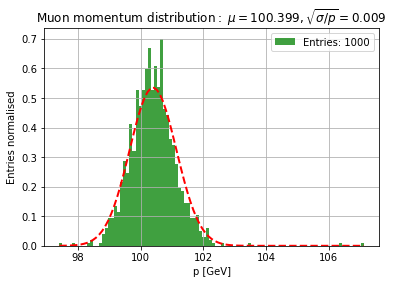

In [80]:
sigma1 = run_tracks('case1', 'B5', B = 0.5, pmin=90, pmax=110, distr = "gauss")

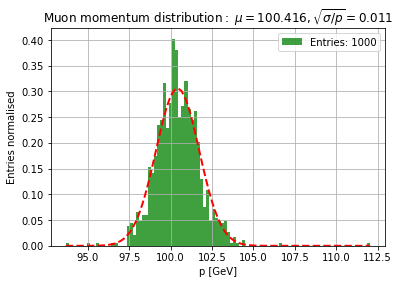

In [81]:
sigma2 = run_tracks('case2', 'B5', B = 0.25,pmin=90, pmax=110, distr = "gauss")

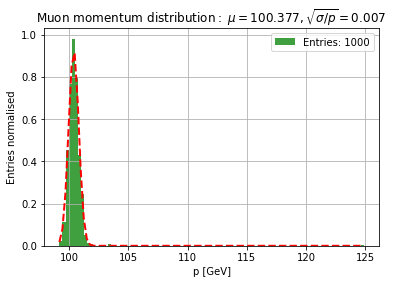

In [82]:
sigma3 = run_tracks('case3', 'B5', B = 1, pmin=80, pmax=110, distr = "gauss")

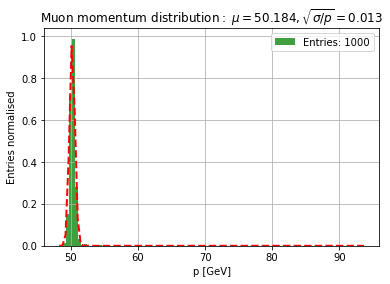

In [83]:
sigma4 = run_tracks('case4', 'B5', 0.5, pmin=45, pmax=55, distr = "gauss")

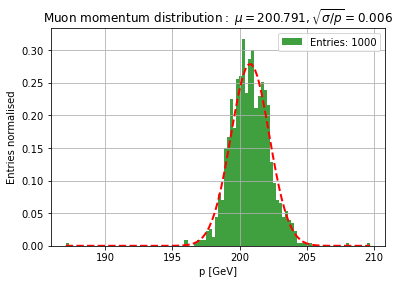

In [84]:
sigma5 = run_tracks('case5', 'B5', 0.5, pmin=190, pmax=210, distr = "gauss")

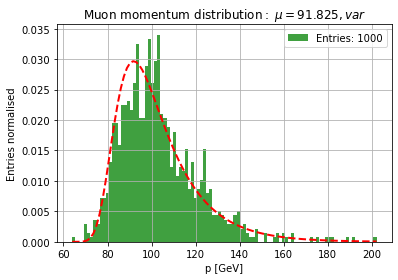

In [85]:
mean8 = run_tracks('case8', 'B5', B = 0.5, pmin=70, pmax=140, distr = "landau") #lead sheet before magnet

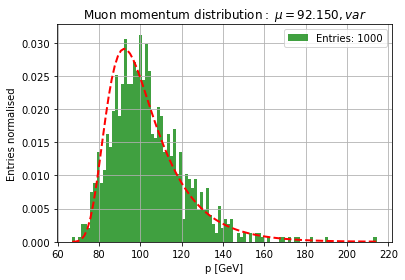

In [86]:
mean9 = run_tracks('case9', 'B5', B = 0.5, pmin=70, pmax=140, distr = "landau") # lead sheet after magnet

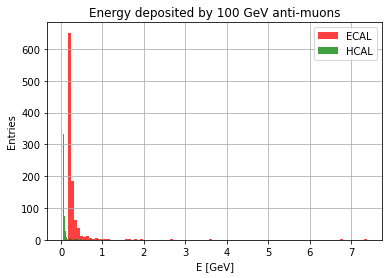

In [88]:
energy('case1', 'B5', title = 'Energy deposited by 100 GeV anti-muons', bin1 = 0.0, bin2 = 10.0)

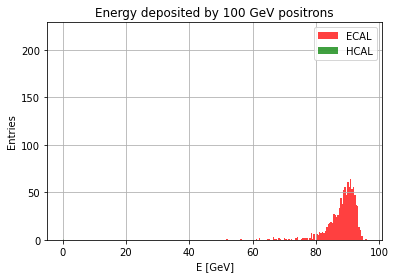

In [89]:
energy('case6', 'B5', title = 'Energy deposited by 100 GeV positrons', bin1 = 0, bin2 = 150)

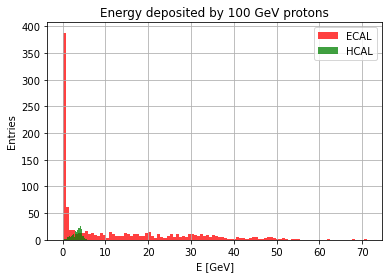

In [90]:
energy('case7', 'B5', title = 'Energy deposited by 100 GeV protons', bin1 = 0, bin2 = 50)

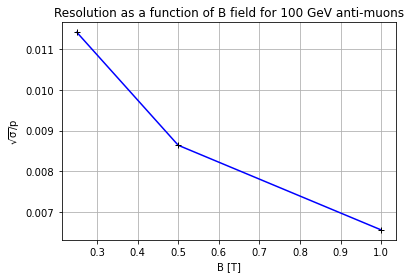

In [54]:
sigmas_B = np.array([sigma2, sigma1, sigma3]) # 100 GeV muons
sigmas_p = np.array([sigma4, sigma1, sigma5])
B = [0.25, 0.5, 1]
p = [50, 100, 200]

plt.plot(B, sigmas_B/100, 'b')
plt.plot(B, sigmas_B/100, 'k+')
plt.xlabel('B [T]')
plt.ylabel(r'$\mathrm{\sqrt{\sigma}/p}$')
plt.title("Resolution as a function of B field for 100 GeV anti-muons")
plt.grid(True)
plt.show()  

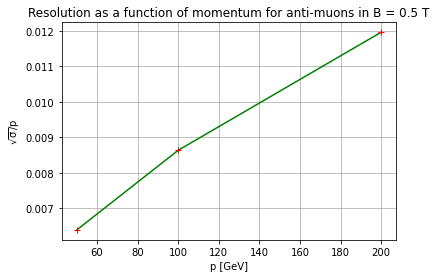

In [55]:
plt.plot(p, sigmas_p/100, 'g')
plt.plot(p, sigmas_p/100, 'r+')
plt.xlabel('p [GeV]')
plt.ylabel(r'$\mathrm{\sqrt{\sigma}/p}$')
plt.title("Resolution as a function of momentum for anti-muons in B = 0.5 T")
plt.grid(True)
plt.show() 